In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import regreg.api as rr
from regreg.affine import composition, reshape

In [2]:
nvox = 100
ntr = 150
nbasis = 300

In [3]:
# beta parameter matrix for design assumed sparse
X = np.random.standard_normal((ntr, nbasis))
# Data
Y = np.random.standard_normal((ntr, nvox))

In [4]:
loss = rr.squared_error(X, Y)
loss.shape = (nbasis, nvox)
loss

affine_smooth(quadratic((150,), coef=1, Q=None, Qdiag=False, offset=[[-0.65101859 -0.15605242 -0.08157678 ...,  0.01229965  1.63998523
   0.0836125 ]
 [-0.55842066 -0.22642011  0.92799184 ...,  2.22984358  0.69828826
   0.59690599]
 [ 0.60488698  0.81189729  0.22037411 ..., -0.02583309  0.33668437
   1.08019873]
 ..., 
 [ 1.68258962 -0.16720304 -1.43531354 ...,  1.01514457 -0.50306558
  -0.97993058]
 [-0.61484572 -0.28233472 -0.1625493  ..., -0.18256476  0.0508806
   0.80625004]
 [ 0.33554121  0.17128919  0.84358452 ...,  0.69155909  0.20894208
  -0.93549902]]), <regreg.affine.linear_transform object at 0x1097b4490>, store_grad=True)

In [5]:
penalty = rr.l1_l2(loss.shape, lagrange=1.)
penalty.shape

(300, 100)

In [6]:
dual_penalty = penalty.conjugate
lam_max = dual_penalty.seminorm(
    loss.smooth_objective(np.zeros(loss.shape), 'grad'),
    lagrange=1)
lam_max

166.14981369096461

In [7]:
penalty.lagrange = 0.95*lam_max
penalty

l1_l2((300, 100), lagrange=157.842323, offset=None)

In [8]:
problem = rr.simple_problem(loss, penalty)
problem

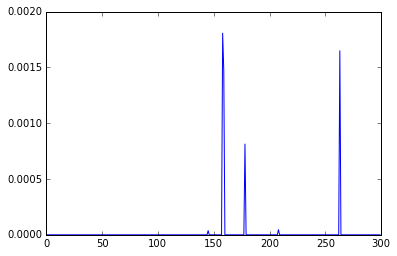

In [7]:
beta = problem.solve(min_its=100, tol=1.e-10)
plt.plot((beta**2).sum(1))

# Using groups and a design

In [27]:
# A design with experimental manipulations, where betas not sparse
nbasis = 10
design = np.random.standard_normal((ntr, nbasis))
X_d = np.hstack([design, X]) # prepended columns for design
X_d.shape

(150, 310)

### Method 1: reusing above method on residuals 

In [9]:
design_pinv = np.linalg.pinv(design)
# Projector onto space of experimental design
P_design = np.dot(design, design_pinv)
# Residual-forming matrix
R_design = np.eye(ntr) - P_design
# Residuals of data w.r.t design
resid_design = np.dot(R_design, Y)

# X matrix for problem should be residualized w.r.t. design as well 
# -- important
X_ort_design = np.dot(R_design, X)

loss_resid = rr.squared_error(X_ort_design, resid_design)
loss_resid.shape = (300, nvox)

In [10]:
lam_max = dual_penalty.seminorm(loss_resid.smooth_objective(np.zeros(loss_resid.shape), 'grad'), lagrange=1.)
penalty.lagrange = 0.9 * lam_max

In [11]:
# Residual problem after orthogonalizing w.r.t experimental design
problem_resid = rr.simple_problem(loss_resid, penalty)
problem_resid

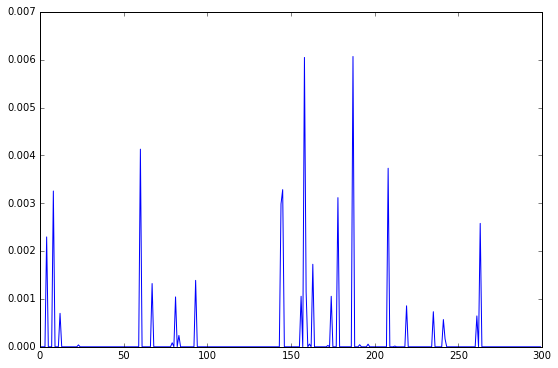

In [12]:
soln_resid = problem_resid.solve(min_its=200, tol=1.e-12)
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
ax.plot((soln_resid**2).sum(1))

### Method 2: using group LASSO with 0 weights

In [28]:
groups = np.outer(np.arange(X_d.shape[1]), np.ones(nvox))
groups.shape

(310, 100)

In [30]:
groups[:nbasis] = design_label = -1 # group id for design columns
groups = groups.reshape(-1)

array([  -1.,   -1.,   -1., ...,  309.,  309.,  309.])

In [29]:
# All groups have weight 1 except experimental design (weight 0)
weights = dict([(g, 1.) for g in np.unique(groups)])
weights[design_label] = 0

In [33]:
# form loss when parameterized with groups
ncolX = X_d.shape[1]
X_trans = composition(X_d, reshape(nvox * ncolX, (ncolX, nvox)))
loss_group = rr.squared_error(X_trans, Y)
loss_group.shape

31000

In [15]:
# Weights apply penalty only to non-experimental parameters
penalty_group = rr.group_lasso(groups,  weights=weights, lagrange=penalty.lagrange)
problem_group = rr.simple_problem(loss_group, penalty_group)
problem_group

In [16]:
soln_group = problem_group.solve(min_its=200, tol=1.e-12)
soln_reshape = soln_group.reshape(ncolX, nvox)
outlier_coef = soln_reshape[nbasis:]

### Solutions are the same for outlier coefs

2.57902611e-15 0.224692853721


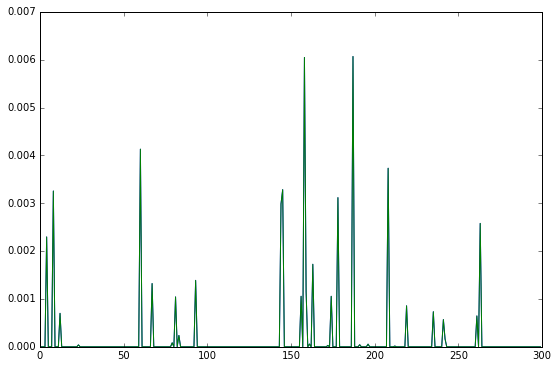

In [17]:
print np.linalg.norm(soln_resid - outlier_coef) / np.linalg.norm(outlier_coef), np.linalg.norm(outlier_coef)
ax.plot((outlier_coef**2).sum(1))
fig

### Reconstructing design coefs from the residual solution

In [18]:
coefs_resid = np.dot(design_pinv, Y - np.dot(X, soln_resid))
np.linalg.norm(coefs_resid - soln_reshape[:nbasis]) / np.linalg.norm(soln_reshape), np.linalg.norm(soln_reshape)

(9.8194412852878386e-16, 2.5959056093005803)

## Why are solutions the same?

The optimization problem `problem_group` can be written as
$$
\text{minimize}_{A, B} \frac{1}{2} \|Y-XB-DA\|^2_F + \lambda \sum_{g \in G} w_g \|B[g]\|_2
$$
where $X$ is the outlier design and $D$ is the model design.

In turn, this could be written as
$$
\text{minimize}_{\tilde{B}} \frac{1}{2} \|Y-\tilde{X}\tilde{B}\|^2_F + \lambda  \sum_{g \in \tilde{G}} w_g \|\tilde{B}[g]\|_2
$$
where we have used `hstack` to make a larger design and the $w_g$ for the design columns is just zero.
This latter form is how it is solved using `problem_group`.

Returning to the former version, for a given $B$ we can explicitly solve for $A$
$$
\hat{A}(Y,B) = P_D(Y-XB)
$$
where
$$
P_D = D D^{\dagger}.
$$

Plugging in the optimal value $\hat{A}(Y,B)$, we still have to find $B$. The objective is now
$$
\text{minimize}_{B} \frac{1}{2} \|(I-P_D)(Y-XB)\|^2_F + \lambda \sum_{g \in G} w_g \|B[g]\|_2
$$
or,
$$
\text{minimize}_{B} \frac{1}{2} \|R_DY-(R_DX)B\|^2_F + \lambda  \sum_{g \in G} w_g \|B[g]\|_2
$$
where $R_D = I - P_D$.

If we assign all groups equal weights of 1, which we specified in the dict `weights`, then
$$
\sum_{g \in G} w_g \|B[g]\|_2 = \|B\|_{1,2}
$$
and our problem is
$$
\text{minimize}_{B} \frac{1}{2} \|R_DY-(R_DX)B\|^2_F + \lambda \|B\|_{1,2}.
$$

This is the problem solved by `problem_resid`. Having solved for $\hat{B}(R_DY)$ we plug this into the
formula for $\hat{A}$ yielding `coefs_resid` above.